In [1]:
import json
import tensorflow as tf

In [2]:
def comp(x):
    '''
    bilinear transformation
    '''
    a = x[0]
    b = x[1]
    c = tf.einsum('aik,apkj,aij->aip', b, a, b)
    return c

def mxmake(m):
    '''
    Three 4x4 matrices from one 30-component vector 
    '''
    cc = tf.reshape(m,(-1,3,10))
    ee = tf.constant([
        [[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]],
        [[0,1,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]],
        [[0,0,1,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]],
        [[0,0,0,1],[0,0,0,0],[0,0,0,0],[0,0,0,0]],
        [[0,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]],
        [[0,0,0,0],[0,0,1,0],[0,0,0,0],[0,0,0,0]],
        [[0,0,0,0],[0,0,0,1],[0,0,0,0],[0,0,0,0]],
        [[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,0]],
        [[0,0,0,0],[0,0,0,0],[0,0,0,1],[0,0,0,0]],
        [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]]
    ], dtype=tf.float32)
    mx = tf.einsum('...j,jkl->...kl',cc,ee)
    return mx

def vecmake(x):
    '''
    Extending vector with a constant 
    '''
    return tf.pad(x, tf.constant([[0,0],[0,0],[0,1]]), "CONSTANT", constant_values=1)

### Loading model

In [3]:
with open('model/heavy.json', 'r') as json_file:
    cfg = json.load(json_file)

In [4]:
md = tf.keras.models.model_from_json(cfg)

2021-10-27 02:27:00.903311: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-27 02:27:00.905725: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
md.summary()

Model: "coder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 378, 504, 3) 0                                            
__________________________________________________________________________________________________
ll_relu_0 (Conv2D)              (None, 378, 504, 61) 1708        input_1[0][0]                    
__________________________________________________________________________________________________
ll_th_0 (Conv2D)                (None, 378, 504, 3)  1650        ll_relu_0[0][0]                  
__________________________________________________________________________________________________
ll_add_0 (Add)                  (None, 378, 504, 3)  0           input_1[0][0]                    
                                                                 ll_th_0[0][0]                

In [6]:
md.load_weights('model/heavy')

### Inference

In [7]:
import numpy as np
from PIL import Image

In [9]:
imageshort = Image.open(r"pic/short_exposure.jpg")
imagemed = Image.open(r"pic/medium_exposure.jpg")

In [10]:
datshort = np.array(imageshort.getdata()).reshape(imageshort.size[1], imageshort.size[0], 3)
datmed = np.array(imagemed.getdata()).reshape(imagemed.size[1], imagemed.size[0], 3)

In [11]:
datshort = datshort / 255
datmed = datmed / 255

In [12]:
datshort.shape

(378, 504, 3)

In [13]:
pred = md.predict(np.expand_dims(datshort, axis=0)).squeeze()

2021-10-27 02:27:34.729159: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [14]:
pred.shape

(378, 504, 3)

In [15]:
from matplotlib import pyplot as plt

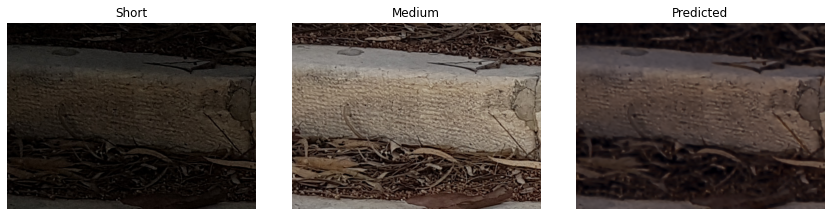

In [20]:
fig, axx = plt.subplots(ncols=3,figsize=(12, 3), sharey=True)

axx[0].imshow(datshort)
axx[0].axis('off')
axx[0].set_title('Short')

axx[1].imshow(datmed)
axx[1].axis('off')
axx[1].set_title('Medium')

axx[2].imshow(np.clip(pred, 0, 1))
axx[2].axis('off')
axx[2].set_title('Predicted')

fig.tight_layout()
plt.show()